# Transfer Learning ด้วย Pretrained CONVNET

**Pretrained network** คือ convolutional network สำหรับการจำแนกประเภทของรูปภาพ ที่ผ่านการเทรนด้วยชุดข้อมูลขนาดใหญ่แล้ว โดยหากชุดข้อมูลที่ใช้เทรนมีขนาดใหญ่และมีความหลากหลายเพียงพอแล้ว ฟีเจอร์เชิงพื้นที่แบบมีลำดับขั้น (spatial hierarchy of features) ที่ pretrained convnet เรียนรู้ได้นั้น สามารถนำไปใช้เป็นโมเดลพื้นฐานสำหรับรูปทรงในการงานด้านการประมวลผลภาพ (computer vision) ปัญหาอื่น ที่ต่างไปจากเดิมได้ 

แนวความคิดในการนำ pretrained convnet ไปใช้ใน computer vision task ที่ต่างจาก computer vision task ที่โมเดลถูกสร้างขึ้นมานี้ เรียกว่า **transfer learning**

![การนำ Pretrained CONVNET มาใช้](images/fig1.jpg)

<center>**รูปที่ 1 การใช้ Pretrained convolutional neural network เป็น Feature Extractor สำหรับ classifier ตัวใหม่**</center>

จากรูปที่ 1 จะเห็นว่า เราจะไม่นำส่วนที่เป็น dense layers ในตอนท้ายของ convnet มาใช้ เนื่องจากเหตุผลหลักสองประการคือ ข้อแรกฟีเจอร์ที่เรียนรู้ได้ในส่วนของ dense layers นี้จะเป็นฟีเจอร์ที่เฉพาะเจาะจงกับปัญหาที่ใช้ในการสร้าง pretrained model ขึ้นมา และข้อสองฟีเจอร์ที่เรียนรู้ได้ในส่วนของ dense layers จะไม่มีข้อมูลเกี่ยวกับตำแหน่งเหลืออยู่ ดังนั้นฟีเจอร์ที่เรียนรู้ได้ใน dense layers นี้ จึงไม่มีประโยชน์กับการประมวลผลภาพที่จำเป็นต้องใช้ข้อมูลเกี่ยวกับตำแหน่งของวัตถุ

ไลบารี่ keras และ deeplearning4j ได้เตรียม pretrained convnet โมเดลไว้ให้กับผู้ใช้หลายตัว โดยสำหรับไลบารี่ deeplearning4j เราสามารถเลือกใช้ pretrained model ได้จากแพกเกจ 
```org.deeplearning4j.zoo``` (ข้อมูลเพิ่มเติมที่ https://deeplearning4j.org/model-zoo) สำหรับไลบารี่ keras pretrained model จะอยู่ในโมดูล ```keras.applications``` (ข้อมูลเพิ่มเติมที่ https://keras.io/applications)

ตัวอย่าง pretrained convnet ใน keras และ deeplearning4j
* VGG16
* VGG19
* ResNet50
* InceptionResNetV1
* InceptionResNetV2

### ตัวอย่างการนำ Pretrained CONVNET (VGG16) มาใช้สร้าง Cat/Dog Classifier

#### Load Data

In [1]:
# load modules
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# setup dataset paths
base_dir = 'data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# setup the Image data generator
## augment the training dataset
## by rotation, shifting, shearing, zoom, flip operations
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size =(150, 150),
            batch_size=20,
            class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Load the Pretrained Model

In [2]:
from keras.applications import VGG16

# load the pretrained model
conv_base = VGG16(weights='imagenet',   # used weights derived by pre-training on ImageNet 
                  include_top=False,    # do not include the dense layer
                  input_shape=(150, 150, 3))  # if not specified, 
                                              # the network will be able 
                                              # to process input of any size
        
# Freeze the network by setting its trainable attribute to False
# this is done to prevent weights in the convolutional base from 
# being updated during training.
conv_base.trainable = False

In [3]:
# show a summary of model architecture
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### สร้างโมเดล โดยการเพิ่ม Dense Layer บน convolutional base

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


#### เทรนโมเดลใหม่

In [6]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50)

Epoch 1/30
100/100 [==============================] - 50s 503ms/step - loss: 0.4804 - acc: 0.7885 - val_loss: 0.3728 - val_acc: 0.8590
Epoch 2/30
100/100 [==============================] - 50s 502ms/step - loss: 0.4294 - acc: 0.8135 - val_loss: 0.3468 - val_acc: 0.8330
Epoch 3/30
100/100 [==============================] - 50s 500ms/step - loss: 0.3936 - acc: 0.8390 - val_loss: 0.3075 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 31s 311ms/step - loss: 0.3863 - acc: 0.8305 - val_loss: 0.2978 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 24s 235ms/step - loss: 0.3680 - acc: 0.8325 - val_loss: 0.2867 - val_acc: 0.8690
Epoch 6/30
100/100 [==============================] - 23s 235ms/step - loss: 0.3562 - acc: 0.8450 - val_loss: 0.2771 - val_acc: 0.8830
Epoch 7/30
100/100 [==============================] - 24s 235ms/step - loss: 0.3418 - acc: 0.8520 - val_loss: 0.2715 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 2

#### บันทึกโมเดลไว้ใช้งานภายหลัง

In [7]:
model.save('cats_and_dogs_small-vgg16.h5')

#### พล็อตกราฟแสดงประสิทธิภาพระหว่างการเทรน

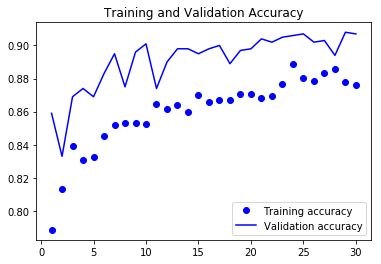

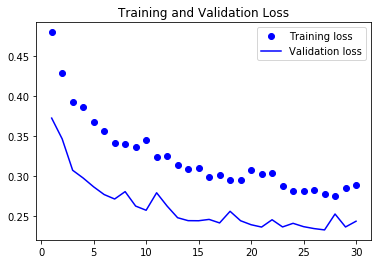

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy Plots
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

#### ประเมินประสิทธิภาพของโมเดลที่ได้บน test data

In [12]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

test acc: 0.8869999969005584
test loss: 0.25696869783103465


### สรุป

* Convolutional neural network (convnet) เป็นโมเดลการเรียนรู้เชิงลึกที่เหมาะสำหรับการประมวลผลภาพ (computer vision)

* เราสามารถสร้าง convnet เองทั้งหมด หรือสร้างต่อยอดจาก pretrained models ต่างๆ เช่น VGG16, VGG19, ResNet

* สำหรับโปรเจ็กต์ที่ชุดข้อมูลมีขนาดเล็ก ปัญหาที่มักพบบ่อยคือ overfitting (โมเดลที่ได้มีประสิทธิภาพที่ดีบนชุดเทรน แต่ไม่ดีบนชุดทดสอบ) วิธีการแก้ปัญหา overfitting มีหลายวิธี เช่น การใช้ dropout layers, การทำ data augmentation, หรือการใช้ Pretrained models
   * ในไลบารี keras และ deeplearning4j มี Pretrained Models เตรียมไว้ให้ใช้งานได้หลายโมเดล เราสามารถนำส่วน convolutional layers ของ pretrained models มาใช้สร้าง convnet ตัวใหม่ได้ โดยการเพิ่ม dense layers เข้าไปบน convolutional base 